In [1]:
# !pip install factor_analyzer
# !pip install psynlig
# !pip install pca

# Reducción de dimensiones. PCA y FA.

# Introducción

En este documento exploramos algunas posibilidades de python para el análisis de reducción de la dimensionalidad del conjunto de datos tanto por Análisis de Componentes Principales (PCA) como por Análisis Factorial (FA). 

Aplicaremos el estudio a los datos "cities.csv" que contiene información sobre características de 21 ciudades en cuanto a indicadores de desarrollo tecnológico, poblaciones, superficie.. Se pretende extraer las componentes o factores que puedan resumir el comportamiento de los datos en baja dimensionalidad con un fin interpretativo. 

Exploramos en particular 3 librerías de python para el ajuste o visualización del PCA: 

1. **PCA de sklearn**. Nos permite ajustar un PCA a los datos e implementa la posibilidad de escoger el número de componentes deseado o el % de variabilidad explicada de la solución propuesta. La visualización no es tan buena. Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
2. **psynlig**. Librería con muchas posibilidades en cuanto a visualización de los resultados de un PCA ajustado con sklearn. Gráficos variados e informativos. Referencia: https://psynlig.readthedocs.io/en/latest/
3. **pca**. Librería que implementa algunas opciones muy interesantes y un automatismo que facilita la interpretación de resultados. Por debajo está utilizando PCA de sklearn. Referencia: https://erdogant.github.io/pca/pages/html/index.html

Para el ajuste del FA recurrimos a dos librerías: 

1. **FactorAnalysis de sklearn**. 
2. **factor_analyzer**. Librería que resulta útil para el cálculo de los tests o criterios de adecuación muestral a priori y para el ajuste de FA por minimización de residuos o máxima verosimilitud. Basado en el paquete psych de R. 

El esquema de trabajo será: 

1. Lectura de datos
2. Evaluación de la adecuación muestral
3. Ajuste de un PCA y evaluación del número de componentes a retener. Screeplot, Kaiser y variabilidad explicada. 
4. Visualizaciones varias del PCA. 
5. Ajuste de un FA con el número de factores previamente seleccionado. 
6. Comparativa PCA vs. FA sin rotación vs. FA con rotación. 

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.express as px

#PCA
from sklearn.preprocessing import StandardScaler, scale
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

#Factor Analysis
from sklearn.decomposition import FactorAnalysis
# pip install factor_analyzer
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

#Encoding
from sklearn.preprocessing import LabelEncoder


Lectura de los datos de ciudades.



In [3]:
# Lectura de datos
cities = pd.read_csv('C:\\Users\\Guille\\Documents\\Material Minería de Datos 2023_2024\\Datos\\cities.csv')

# Fijamos nombres como index de filas
cities.set_index(['City'],inplace=True)
cities


Area  Pop 1980  Pop 1990  Pop 2000  Growth  Food  \
City                                                                      
Buenos Aires     700.000000      9918     11448     12822     1.4    40   
Dhaka            100.000000      3290      6578     11511     7.2    63   
Rio de Janeiro   650.000000      8789     10948     12162     2.2    26   
Sao Paolo        800.000000     12101     18119     22552     4.1    50   
Beijing         1680.000000      9029     10867     14366     1.9    52   
Shanghai         630.000000     11739     13447     17407     1.4    55   
Tianjin          400.000000      7268      9249     12508     2.4    52   
Cairo             21.400000      6852      8633     10761     2.3    47   
Bombay            60.000000      8067     12223     18142     4.2    57   
Calcutta         130.000000      9030     10741     12675     1.8    60   
Delhi             59.099998      5559      8171     11692     3.9    40   
Jakarta           59.000000      5985      9206     13380     4.4    45   
Osaka            200.000000      9990     10482     10601     0.5    18   
Tokyo            216.000000     21854     25013     27956     1.4    18   
Seoul            165.000000      8283     10979     12949     2.9    34   
Mexico City      250.000000     13888     15085     16190     0.8    41   
Lagos             40.000000      4385      7742     13480     5.8    58   
Karachi          353.000000      5023      7943     11895     4.7    43   
Manila            64.000000      5966      8882     12582     4.1    38   
Los Angeles     1660.000000      9523     11456     13151     1.9    12   
New York         359.000000     15601     16056     16645     0.3    16   

                PersRoom  Water  Elec  Phones  Vehicles  
City                                                     
Buenos Aires         1.3     80    91      14      1000  
Dhaka                2.4     60    85       2       600  
Rio de Janeiro       0.8     86    98       8      4000  
Sao Paolo            0.8    100   100      16      4000  
Beijing              1.2     88    90       2       308  
Shanghai             2.0     95    95       4       148  
Tianjin              1.3     80    84       4       200  
Cairo                1.5     91    98       4       939  
Bombay               4.2     92    78       5       588  
Calcutta             3.0     51    63       2       500  
Delhi                3.1     50    81       5      1660  
Jakarta              3.4     75    94       3      1380  
Osaka                0.6     96   100      42      4400  
Tokyo                0.9    100   100      44      4400  
Seoul                2.0    100   100      22      2660  
Mexico City          1.9     92    97       6      2500  
Lagos                5.8     47    53       1       500  
Karachi              3.3     66    84       2       650  
Manila               3.0     89    93       9       510  
Los Angeles          0.5     91    98      35      8000  
New York             0.5     99   100      56      1780

# Adecuación muestral 

Antes de realizar cualquier tipo de análisis de reducción de dimensiones, es conveniente estudiar la adecuación muestral de los datos en cuanto a la estructura de correlación global de las variables. La idea fundamental es que si no existe una estructura de varianzas compartidas entre las variables, las direcciones en el espacio entre las mismas serán más bien ortogonales y, por tanto, no hay componente en el mundo que pueda situarse correctamente para captar información de varias variables... El PCA o el FA están abocados al fracaso. 

1. **Matriz de correlaciones entre las variables**. Nos interesa siempre bien de color o, lo que es lo mismo, valores de correlación altos ya que eso es síntoma de estructura de varianzas compartidas y nos viene bien para captar esa varianza común con una buena componente situada correctamente. 


In [4]:
corr = cities.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=3)


2. **Test de esferidad de Bartlett**. Compara la matriz de correlaciones con una matriz identidad para extraer un p-valor. La hipótesis nula del contraste es H0: Matriz de correlaciones = Matriz identidad, por lo que nos interesa rechazarla! Recordemos que una matriz identidad tiene componentes absolutamente ortogonales, osea 0 correlación o varianza compartida. 



In [5]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
calculate_bartlett_sphericity(cities)


(260.58638573423383, 1.7307379123168752e-28)

Valor del estadístico muy alto y p-valor muy pequeño --> Rechazo claro de la hipótesis nula, tiene buena pinta!

3. **KMO-MSA global y por variable**. Índice de adecuación muestral o de Kaiser-Meyer-Olkin para comparar la correlación observada entre pares de variables y sus correspondientes correlaciones parciales (una vez eliminado el efecto de otras variables presentes). Buscamos valores superiores a 0.5 y cuanto más cercanos a 1, mejor. 


In [6]:
from factor_analyzer.factor_analyzer import calculate_kmo
print(calculate_kmo(cities))

calculate_kmo(cities.drop(['Area'], axis=1))


(array([0.37839405, 0.73406257, 0.65472742, 0.54972228, 0.63108988,
       0.66495328, 0.64841109, 0.65746689, 0.58741765, 0.64646754,
       0.72185201]), 0.63828230219189)


(array([0.72527449, 0.72625267, 0.65315796, 0.57245851, 0.65766469,
        0.71652626, 0.63588764, 0.57609255, 0.66483853, 0.6960587 ]),
 0.6621572547528668)

La variable Area tiene un msa muy bajo por lo que nos planteamos si eliminarla del análisis para ganar estructura compartida. 


# Escalado de datos

Unidades de medida distintas implican necesidad de escalar los datos para que las variables con mayor escala de medida no "pesen" más de lo que deben en la solución. 


In [7]:
scaler = StandardScaler()
scaler.fit(cities)
X = scaler.transform(cities)
#X
pd.DataFrame(X)

0         1         2         3         4         5         6   \
0   0.618192  0.185518 -0.033158 -0.419676 -0.811998 -0.078963 -0.568831   
1  -0.657997 -1.414550 -1.218855 -0.739158  2.462882  1.446603  0.242280   
2   0.511843 -0.087034 -0.154893 -0.580514 -0.360291 -1.007568 -0.937518   
3   0.830890  0.712517  1.591027  1.951466  0.712515  0.584326 -0.937518   
4   2.702633 -0.029096 -0.174614 -0.043412 -0.529681  0.716984 -0.642568   
5   0.469303  0.625127  0.453537  0.697661 -0.811998  0.915971 -0.052670   
6  -0.019902 -0.454220 -0.568548 -0.496196 -0.247364  0.716984 -0.568831   
7  -0.825177 -0.554646 -0.718525 -0.921929 -0.303827  0.385340 -0.421356   
8  -0.743076 -0.261333  0.155531  0.876776  0.768978  1.048629  1.569552   
9  -0.594187 -0.028854 -0.205291 -0.455499 -0.586144  1.247616  0.684704   
10 -0.744990 -0.866790 -0.831008 -0.695050  0.599588 -0.078963  0.758441   
11 -0.745203 -0.763949 -0.579017 -0.283694  0.881905  0.252682  0.979653   
12 -0.445299  0.202900 -0.268350 -0.960920 -1.320169 -1.538200 -1.084992   
13 -0.411267  3.066994  3.269506  3.268387 -0.811998 -1.538200 -0.863780   
14 -0.519743 -0.209188 -0.147345 -0.388727  0.034954 -0.476937 -0.052670   
15 -0.338950  1.143918  0.852340  0.401085 -1.150779 -0.012634 -0.126407   
16 -0.785616 -1.150206 -0.935456 -0.259325  1.672394  1.114958  2.749349   
17 -0.119871 -0.996186 -0.886519 -0.645580  1.051296  0.120024  0.905916   
18 -0.734568 -0.768536 -0.657901 -0.478162  0.712515 -0.211621  0.684704   
19  2.660094  0.090161 -0.031210 -0.339500 -0.529681 -1.936174 -1.158730   
20 -0.107109  1.557454  1.088749  0.511966 -1.433096 -1.670858 -1.158730   

          7         8         9         10  
0  -0.134175  0.111714  0.023741 -0.478712  
1  -1.308202 -0.373663 -0.724109 -0.682594  
2   0.218034  0.677987 -0.350184  1.050408  
3   1.039853  0.839779  0.148383  1.050408  
4   0.335436  0.030818 -0.724109 -0.831428  
5   0.746346  0.435298 -0.599467 -0.912981  
6  -0.134175 -0.454559 -0.599467 -0.886477  
7   0.511541  0.677987 -0.599467 -0.509804  
8   0.570242 -0.939937 -0.537146 -0.688711  
9  -1.836514 -2.153379 -0.724109 -0.733565  
10 -1.895216 -0.697248 -0.537146 -0.142305  
11 -0.427681  0.354402 -0.661788 -0.285023  
12  0.805047  0.839779  1.768725  1.254291  
13  1.039853  0.839779  1.893367  1.254291  
14  1.039853  0.839779  0.522308  0.367401  
15  0.570242  0.597091 -0.474826  0.285848  
16 -2.071320 -2.962341 -0.786430 -0.733565  
17 -0.955994 -0.454559 -0.724109 -0.657109  
18  0.394138  0.273506 -0.287863 -0.728468  
19  0.511541  0.677987  1.332479  3.089234  
20  0.981151  0.839779  2.641217 -0.081140

# Análisis de Componentes Principales (PCA)

Recurrimos a la función PCA de sklearn para obtener la descomposición en valores singulares y el resultado de componentes para los datos. 


In [8]:
pca = PCA() #n_components=0.95
scores = pca.fit_transform(X)
pd.DataFrame(scores)

0         1         2         3         4         5         6   \
0   0.374405 -0.547295  0.625486 -0.305785  0.884903 -0.061483  0.271058   
1  -3.410661 -0.301877 -0.061765  0.240458 -1.350055 -0.710143  1.131066   
2   1.069987 -1.520236  0.056280  0.219424 -0.178410 -0.591955 -0.513279   
3   2.213816  1.377854  1.191234  1.055377 -1.523350 -0.460444  0.216733   
4   0.144974 -0.743459  2.791207  0.645791  0.698063  0.593145  0.397671   
5   0.495090  0.970056  1.652020 -0.751908  0.261812  0.216962 -0.236624   
6  -1.060796 -0.352499  0.817114 -0.642441  0.521682 -0.258866  0.326509   
7  -0.623249 -0.850112  0.293282 -1.598337 -0.345408 -0.333894 -0.253810   
8  -1.518988  1.868306  0.096638 -0.090480 -0.616781  0.940905 -0.499152   
9  -2.454763  0.942389 -0.127141  0.297442  2.091247 -0.638426 -0.128445   
10 -2.317224 -0.389336 -1.102490  0.406441  0.362310 -0.649347  0.026584   
11 -1.634029 -0.025633 -0.411188 -0.312349 -0.916894 -0.040598 -0.298638   
12  2.397831 -1.854149 -1.505841 -0.782374  0.394180  0.079654 -0.043790   
13  5.417498  3.267173 -0.969498  0.612233 -0.085229 -0.379523  0.153234   
14  0.748206 -0.640512 -0.556467 -0.783812 -0.854821  0.402738 -0.221965   
15  1.398946  0.779505  0.386080 -0.672313  0.358181 -0.481344 -1.004796   
16 -4.732310  1.323096 -1.211668  1.486313  0.607737  0.673464 -0.148620   
17 -2.335322 -0.413228 -0.249327  0.246218 -0.276698  0.158781  0.142498   
18 -1.164857 -0.299203 -0.419303 -0.875545 -0.858245  0.604936 -0.054471   
19  3.217147 -2.770765 -0.204369  2.506741 -0.073770  0.291502 -0.358331   
20  3.774298  0.179924 -1.090286 -0.901094  0.899546  0.643937  1.096570   

          7         8         9         10  
0   0.222891 -0.023458 -0.013726  0.089373  
1  -0.260714 -0.145820 -0.194241 -0.075560  
2   0.255615  0.402279 -0.086050  0.010367  
3  -0.484879 -0.018497  0.124847  0.121076  
4   0.306665 -0.005923 -0.032850  0.000780  
5   0.084487 -0.260448  0.078165 -0.103136  
6  -0.345374  0.364436  0.106988 -0.074539  
7  -0.251052  0.049687  0.025063 -0.023671  
8  -0.437983  0.110669  0.065170 -0.026731  
9  -0.469312 -0.053741 -0.007184  0.074395  
10  0.540264 -0.080165  0.232231 -0.009696  
11  0.461912 -0.300437  0.105450  0.010566  
12 -0.573040 -0.099769  0.075396 -0.033701  
13  0.352074  0.149433 -0.015663 -0.062966  
14 -0.240413 -0.069339 -0.075405  0.089030  
15  0.135874 -0.182936 -0.229696 -0.007152  
16 -0.163808  0.042476 -0.086467 -0.012655  
17  0.591561  0.076046 -0.015270  0.033411  
18  0.336447  0.219419 -0.019594  0.025313  
19 -0.167337 -0.102094  0.000490 -0.052178  
20  0.106122 -0.071817 -0.037656  0.027674

**Visualización con paquete *psynlig***



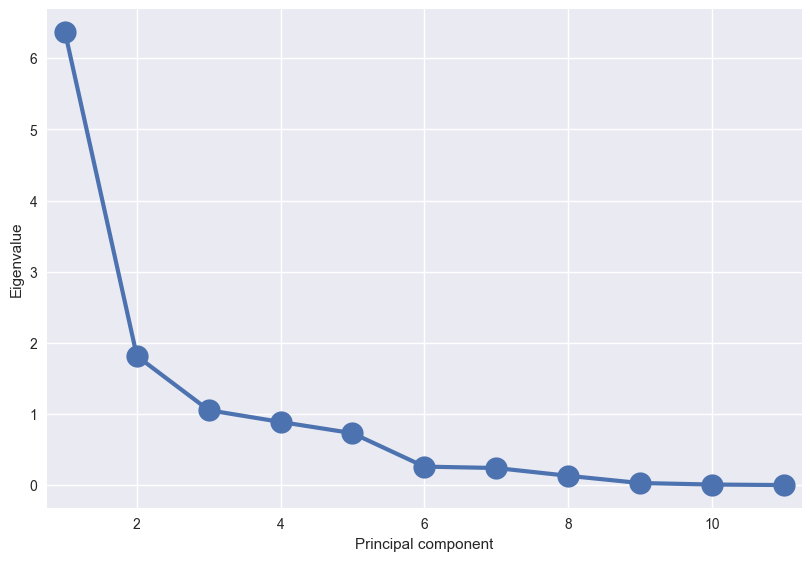

In [9]:
# pip install psynlig
from psynlig import pca_scree
plt.style.use('seaborn-v0_8')

pca_scree(pca, marker='o', markersize=16, lw=3)

plt.show()


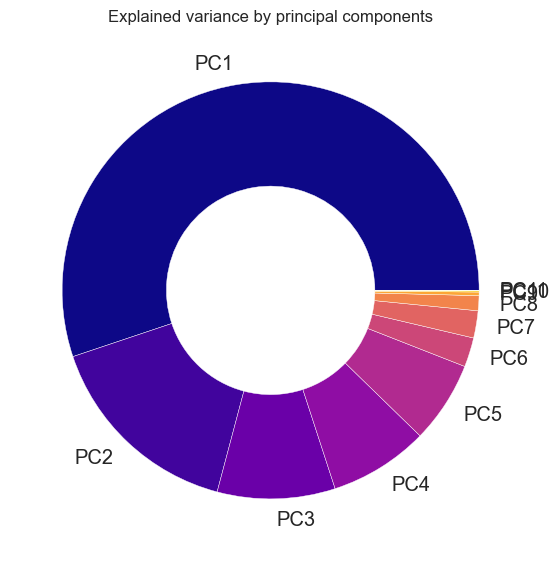

In [10]:
from psynlig import pca_explained_variance_pie
#plt.style.use('seaborn-talk')

fig, axi = pca_explained_variance_pie(pca, cmap='plasma')
axi.set_title('Explained variance by principal components')

plt.show()


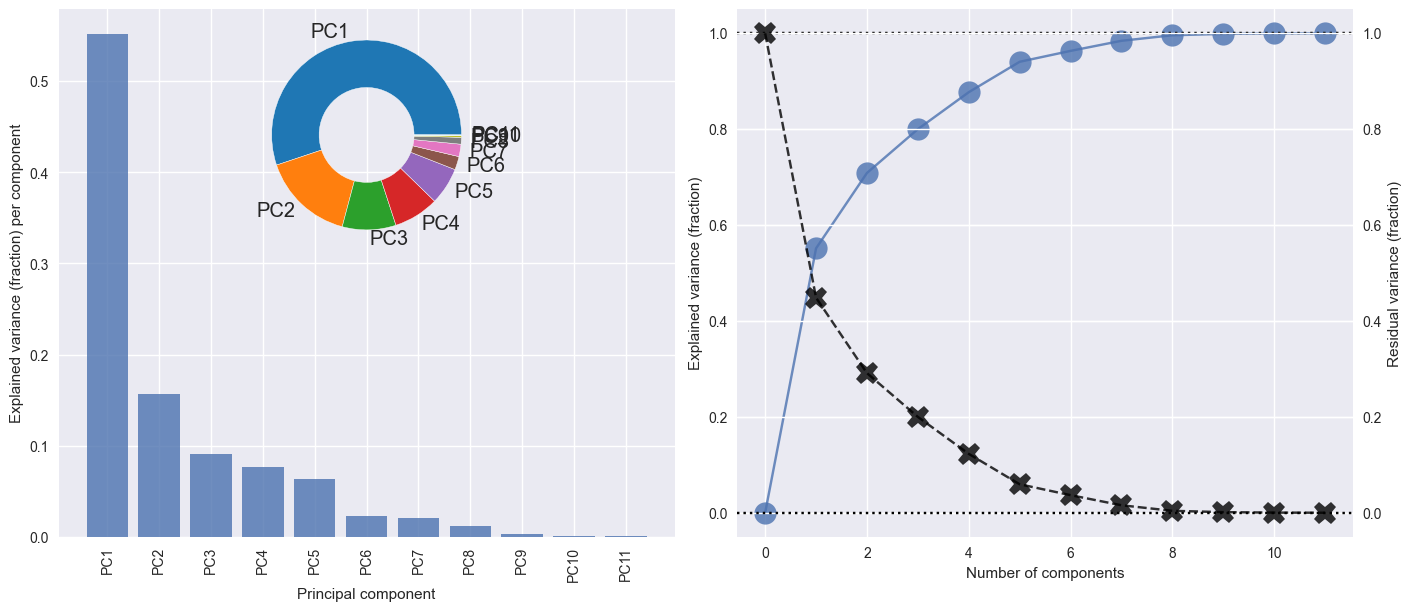

In [11]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from psynlig import (
    pca_explained_variance,
    pca_residual_variance,
    pca_explained_variance_bar,
    pca_explained_variance_pie,
    pca_1d_loadings,
    pca_2d_loadings,
    pca_2d_scores
)

fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2, figsize=(14, 6), constrained_layout=True
)
pca_explained_variance_bar(pca, axi=ax1, alpha=0.8)
pca_explained_variance(pca, axi=ax2, marker='o', markersize=16, alpha=0.8)
ax4 = ax2.twinx()
pca_residual_variance(
    pca,
    ax4,
    marker='X',
    markersize=16,
    alpha=0.8,
    color='black',
    linestyle='--'
)
ax3 = inset_axes(ax1, width='45%', height='45%', loc=9)
pca_explained_variance_pie(pca, axi=ax3, cmap='tab20')
plt.show()


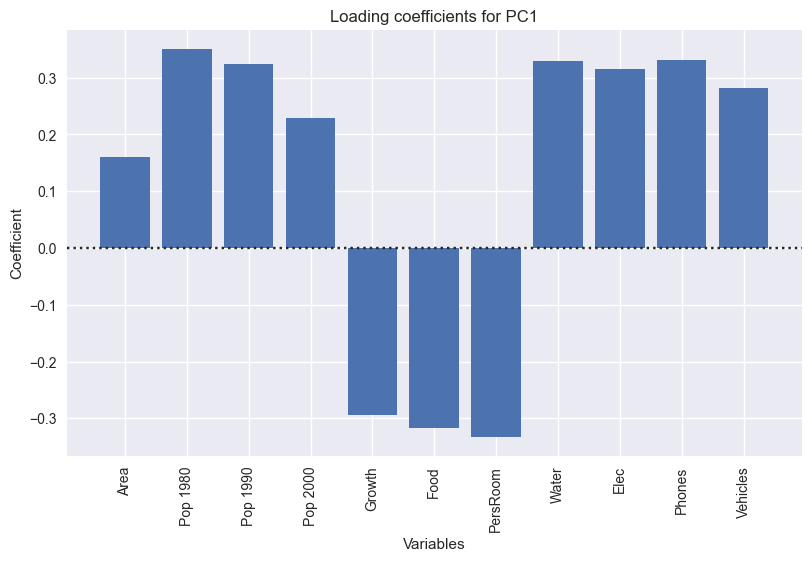

In [12]:
pca_1d_loadings(
        pca,
        cities.columns,
        select_components={1},
        plot_type='bar',
    )
plt.show()


In [13]:
import plotly.express as px
fig = px.scatter(scores, x=0, y=1, text=cities.index)
fig.show()


In [14]:
plt.rcParams["figure.figsize"] = (12,10)

def biplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley) #, c = cities.index.tolist())
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

#Call the function. Use only the 2 PCs.
#biplot(scores[:,0:2],np.transpose(pca.components_[0:2, :]),cities.columns)
plt.show()


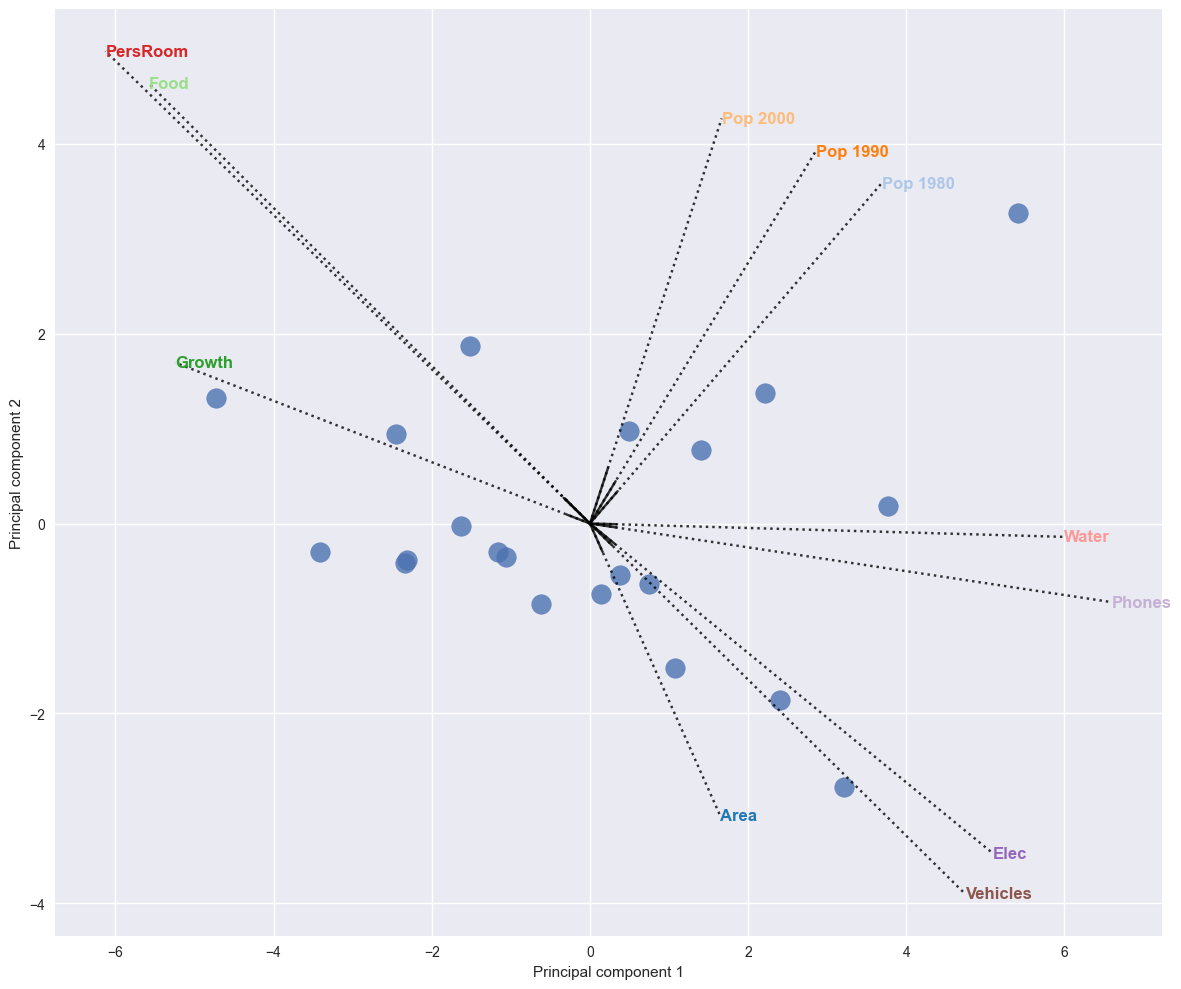

In [15]:
loading_settings = {
    'add_text': True
}
pca_2d_scores(
    pca,
    scores,
    xvars=cities.columns,
    #class_data=class_data,
    #class_names=class_names,
    select_components={(1, 2)},
    loading_settings=loading_settings,
    s=200,
    alpha=.8,
    cmap_class='Dark2',
)

plt.show()


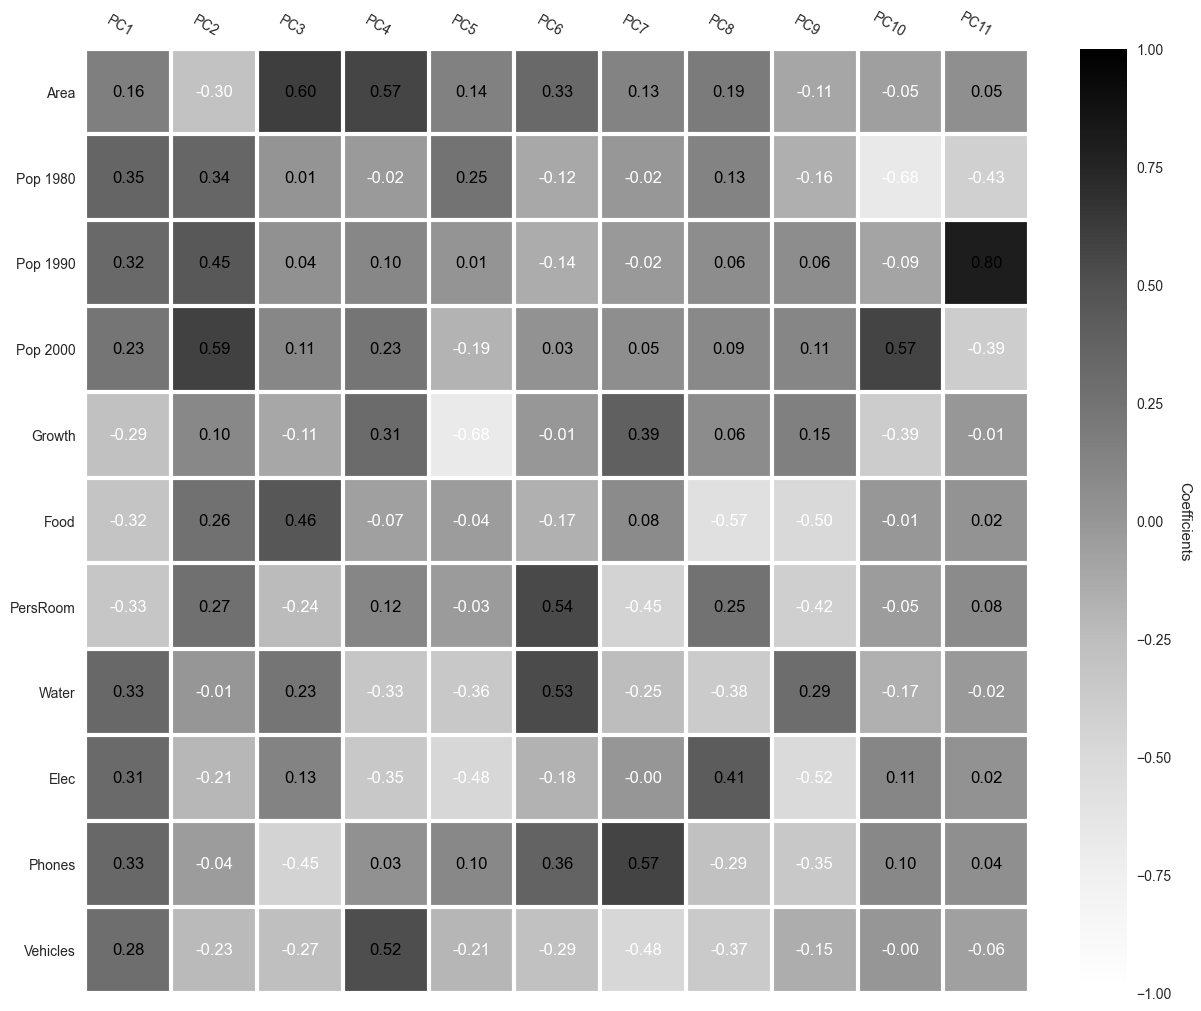

In [16]:
from psynlig import pca_loadings_map
kwargs = {
    'text': {
        'fontsize': 'large',
    },
    'heatmap': {
        'vmin': -1,
        'vmax': 1,
    },
}


# Plot the value of the coefficients:
pca_loadings_map(
    pca,
    cities.columns,
    textcolors=['white', 'black'],
    **kwargs
)
plt.show()


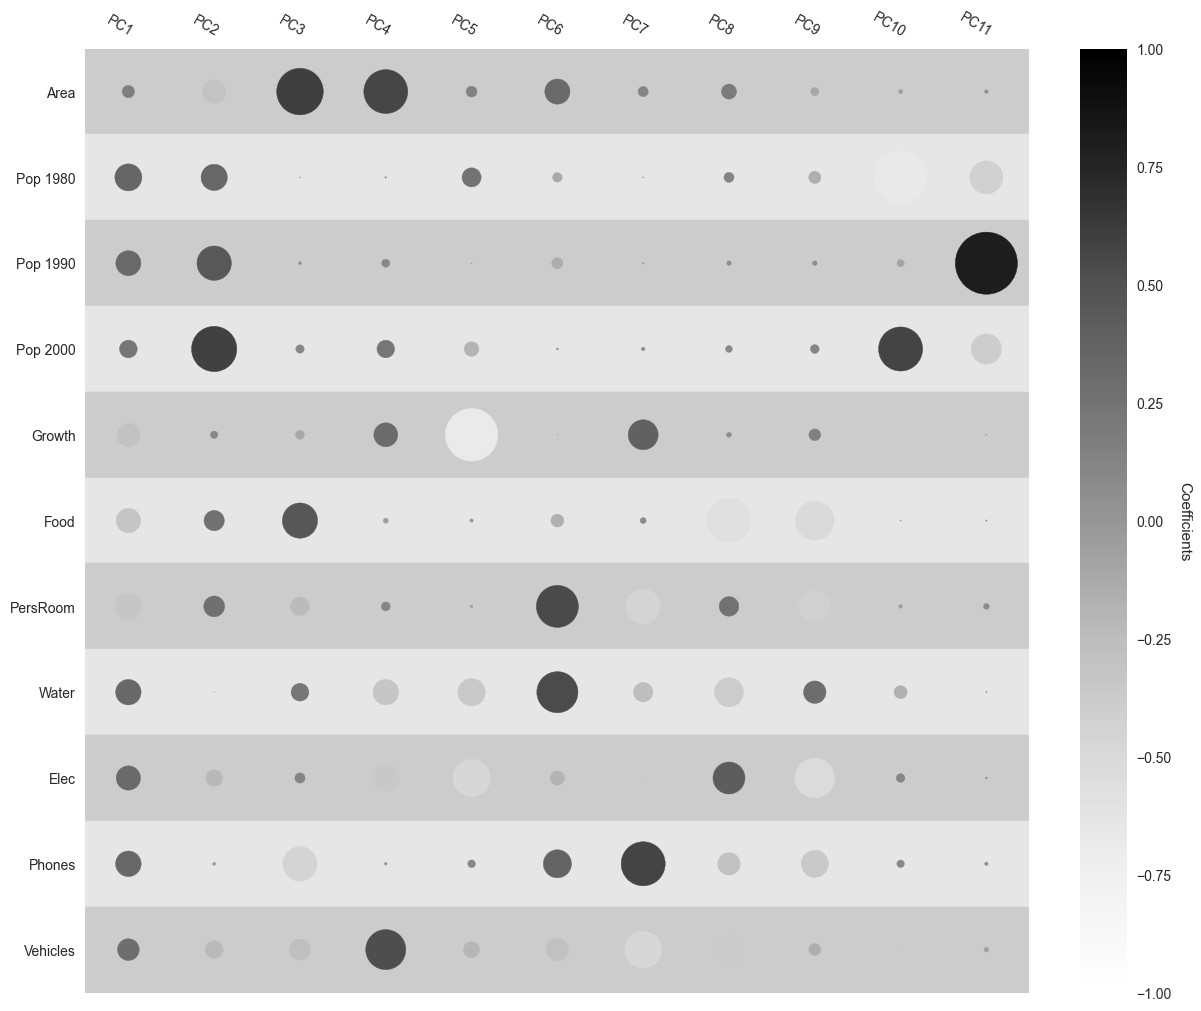

In [17]:
# Plot the value of the coefficients:
pca_loadings_map(
    pca,
    cities.columns,
    bubble=True,
    annotate=False,
    **kwargs
)
plt.show()


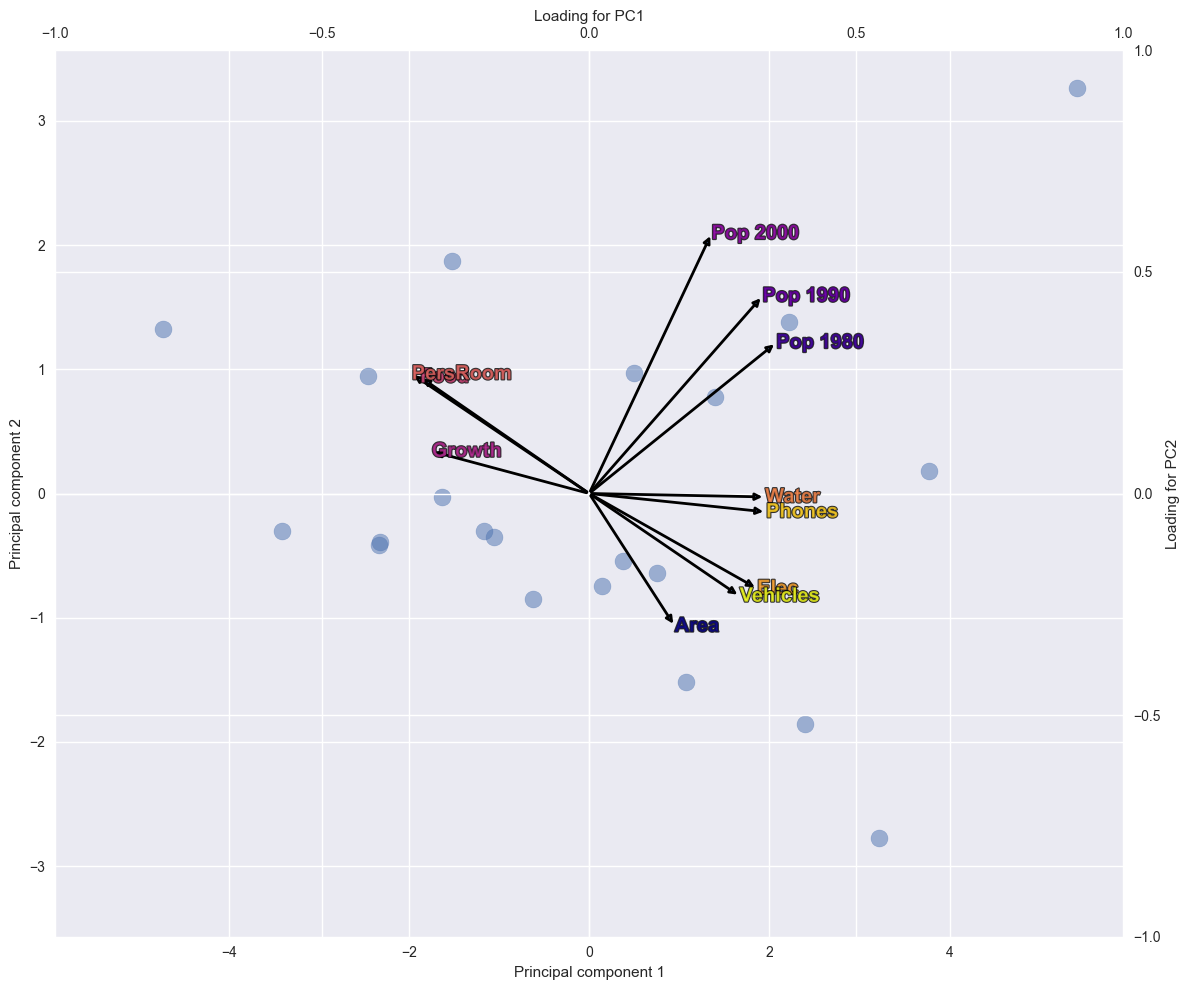

In [18]:
loading_settings = {
    'add_text': True,
    'add_legend': False,
    'biplot': True,
    'text': {
        'fontsize': 'x-large',
        'alpha': 0.8,
        'outline': {'linewidth': 1.5}
    },
}

pca_2d_scores(
    pca,
    scores,
    xvars=cities.columns,
    #class_data=class_data,
    #class_names=class_names,
    select_components={(1, 2)},
    loading_settings=loading_settings,
    s=150,
    alpha=.5,
    cmap_loadings='plasma',
)
plt.show()


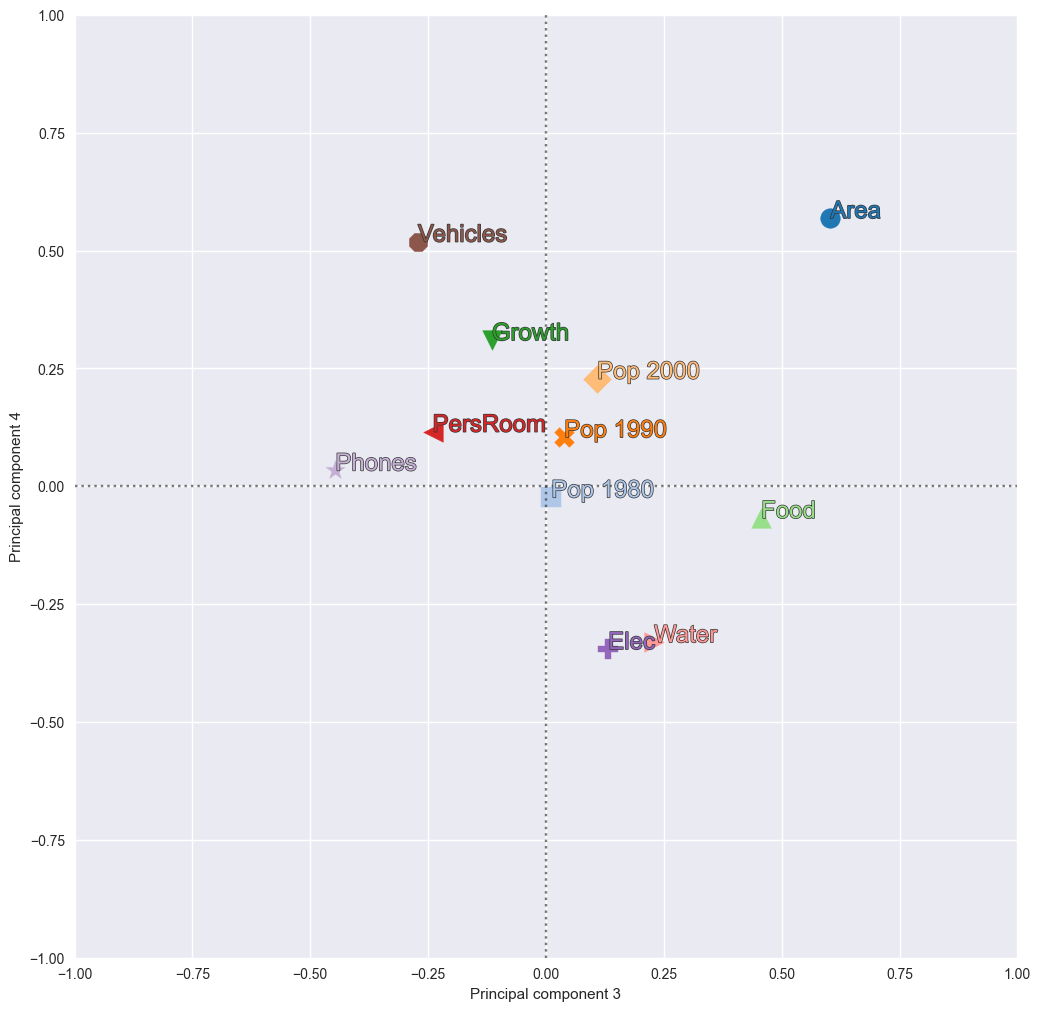

In [19]:
text_settings = {
    'fontsize': 'xx-large',
    'outline': {'foreground': '0.2'}
}

pca_2d_loadings(
    pca,
    cities.columns,
    select_components={(3, 4)},
    text_settings=text_settings
)
plt.show()


## PCA con el paquete *pca*



[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [70.0%] explained variance using the [11] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [2] that covers the [70.00%] explained variance.
[pca] >The PCA reduction is performed on the [11] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


(<Figure size 1500x1000 with 1 Axes>,
 <Axes: title={'center': 'Cumulative explained variance\n 2 Principal Components explain [80.00%] of the variance.'}, xlabel='Principal Component', ylabel='Percentage explained variance'>)

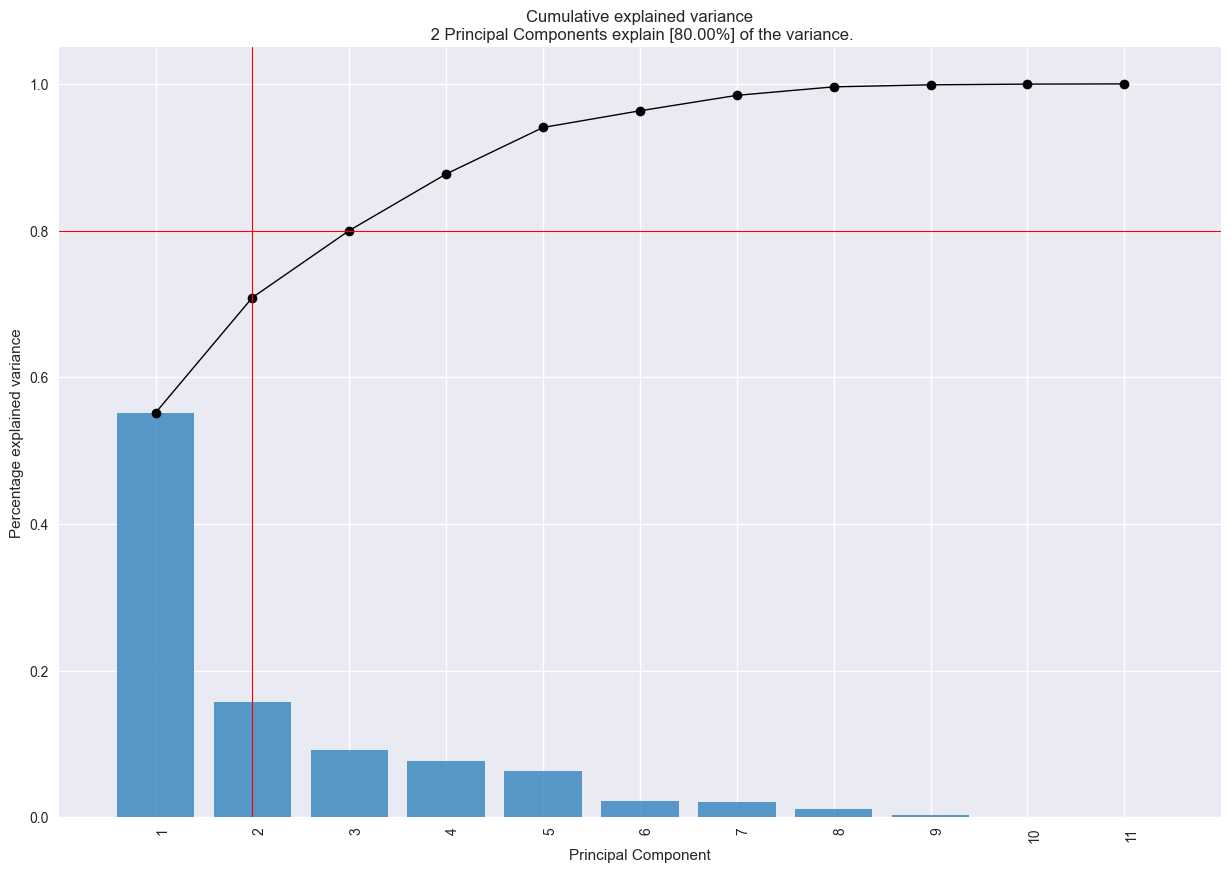

In [20]:
# pip install pca
# Load library
from pca import pca

# Initialize pca with default parameters
model = pca(normalize=True,n_components=0.7)

# Fit transform
results = model.fit_transform(cities)

# Plot the explained variance
model.plot()


In [21]:
model.results



{'loadings':          Area  Pop 1980  Pop 1990  Pop 2000    Growth      Food  PersRoom  \
 PC1  0.160155  0.350227  0.324320   0.22897 -0.294844 -0.316499 -0.332189   
 PC2 -0.299178  0.340310  0.445359   0.58641  0.095274  0.263001  0.269795   
 
         Water      Elec    Phones  Vehicles  
 PC1  0.329585  0.314552  0.331179  0.281742  
 PC2 -0.007733 -0.214427 -0.041567 -0.231643  ,
 'PC':                      PC1       PC2
 Buenos Aires    0.374405 -0.547295
 Dhaka          -3.410661 -0.301877
 Rio de Janeiro  1.069987 -1.520236
 Sao Paolo       2.213816  1.377854
 Beijing         0.144974 -0.743459
 Shanghai        0.495090  0.970056
 Tianjin        -1.060796 -0.352499
 Cairo          -0.623249 -0.850112
 Bombay         -1.518988  1.868306
 Calcutta       -2.454763  0.942389
 Delhi          -2.317224 -0.389336
 Jakarta        -1.634029 -0.025633
 Osaka           2.397831 -1.854149
 Tokyo           5.417498  3.267173
 Seoul           0.748206 -0.640512
 Mexico City     1.398946  0

In [22]:
model.results['loadings']

Area  Pop 1980  Pop 1990  Pop 2000    Growth      Food  PersRoom  \
PC1  0.160155  0.350227  0.324320   0.22897 -0.294844 -0.316499 -0.332189   
PC2 -0.299178  0.340310  0.445359   0.58641  0.095274  0.263001  0.269795   

        Water      Elec    Phones  Vehicles  
PC1  0.329585  0.314552  0.331179  0.281742  
PC2 -0.007733 -0.214427 -0.041567 -0.231643

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': '2 Principal Components explain [80.00%] of the variance'}, xlabel='PC1 (55.1% expl.var)', ylabel='PC2 (15.7% expl.var)'>)

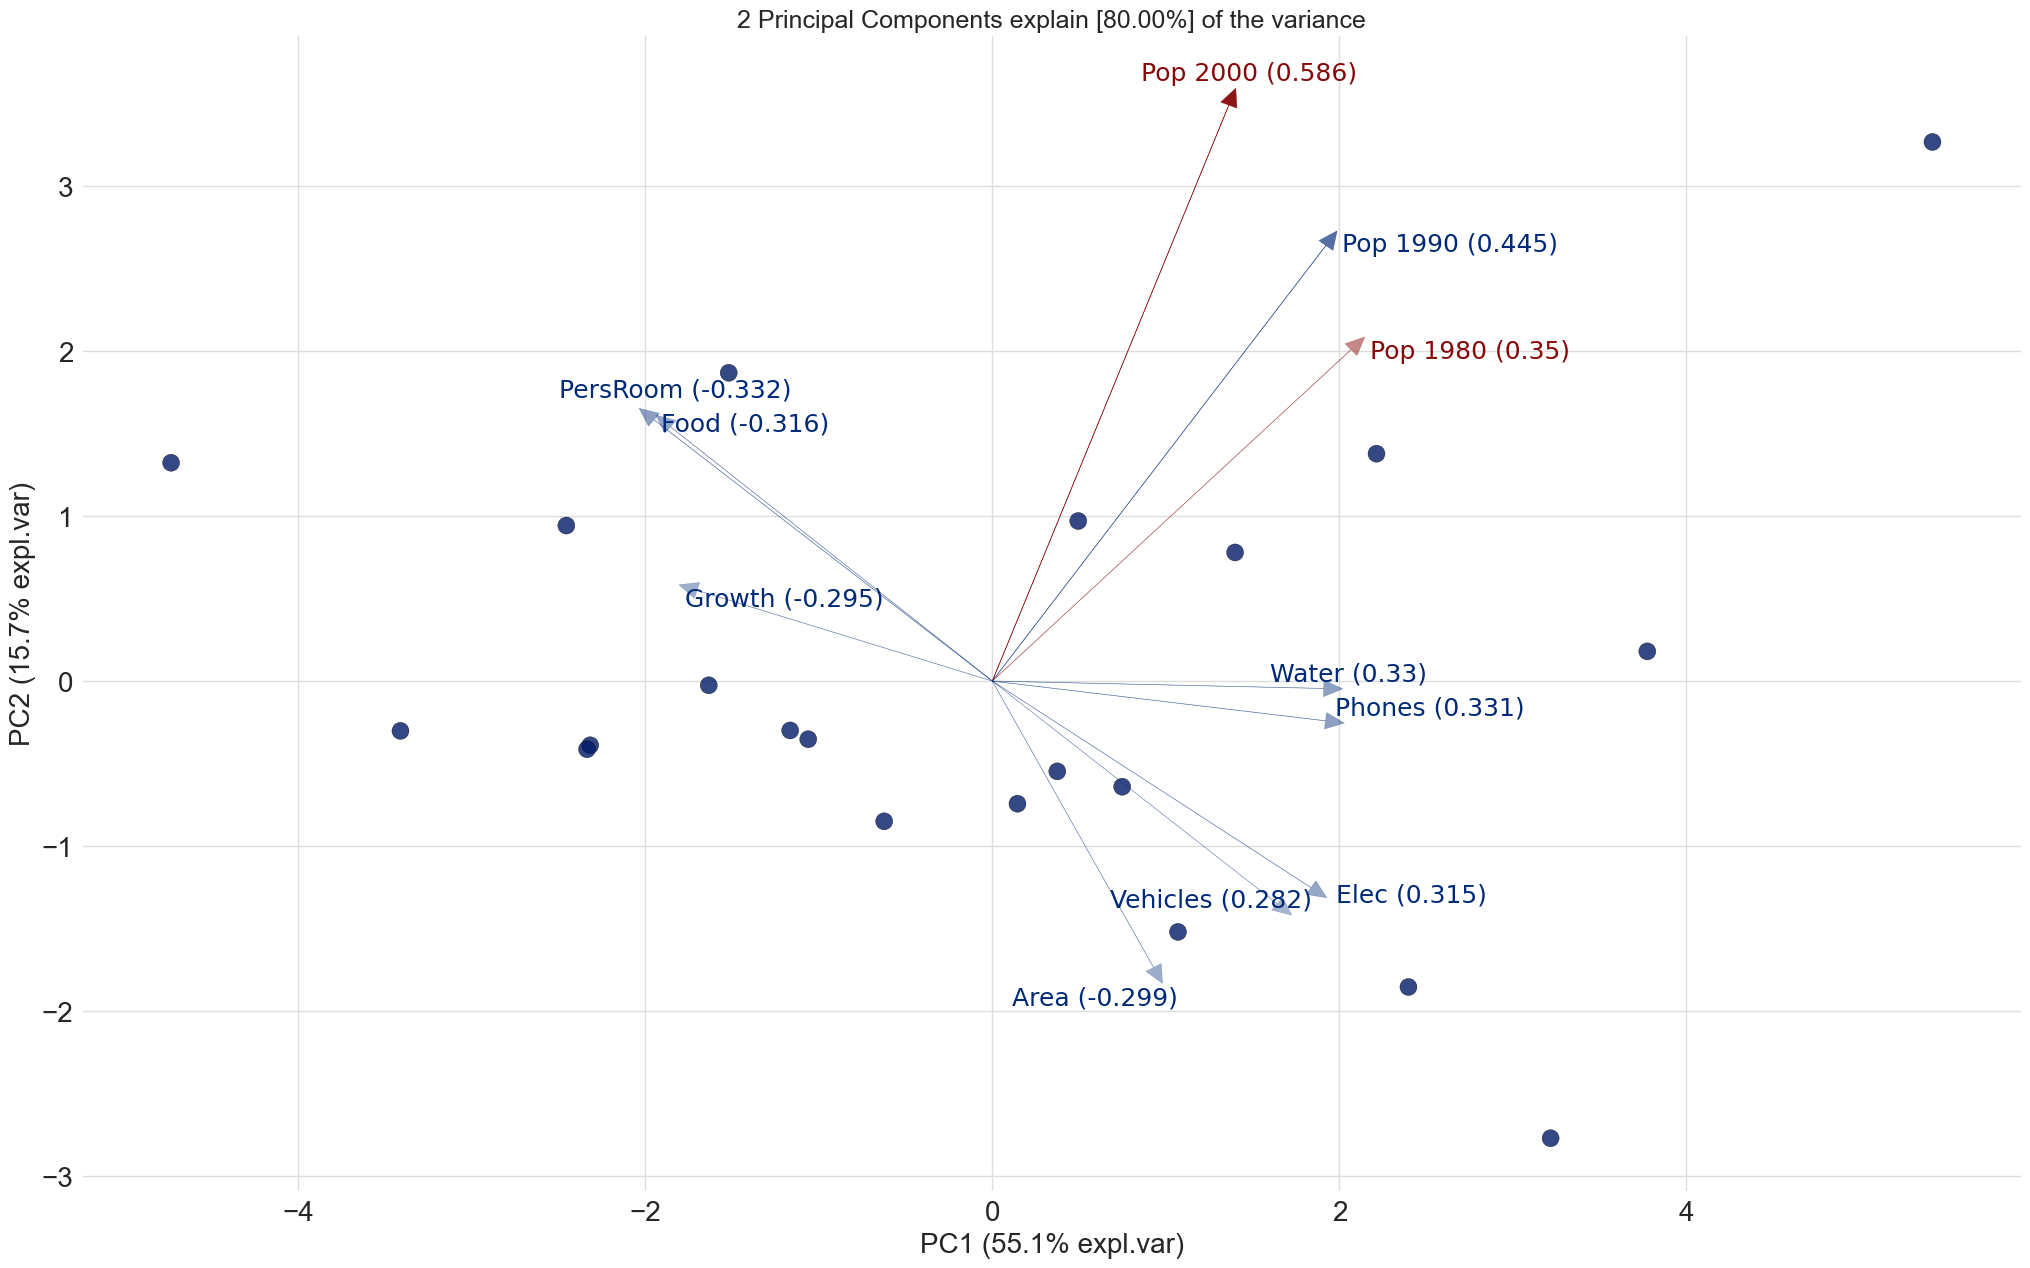

In [23]:
# Plot the explained variance
model.biplot(legend=False)
#plt.show()


# Análisis Factorial

Para el Análisis Factorial vamos a explorar el paquete **factor_analyzer** que implementa el análisis exploratorio con la estimación de parámetros por MINRES (minimización de residuos, por defecto) o ML (máxima verosimilitud). Está inspirado en la implementación de esta técnica en el paquete *psych* de R. 

https://factor-analyzer.readthedocs.io/en/latest/index.html


In [24]:
from factor_analyzer import FactorAnalyzer

fa = FactorAnalyzer(rotation =None, method='minres',n_factors=2) #cities.shape[1]

fa.fit(X)


FactorAnalyzer(n_factors=2, rotation=None, rotation_kwargs={})

**Secree plot**



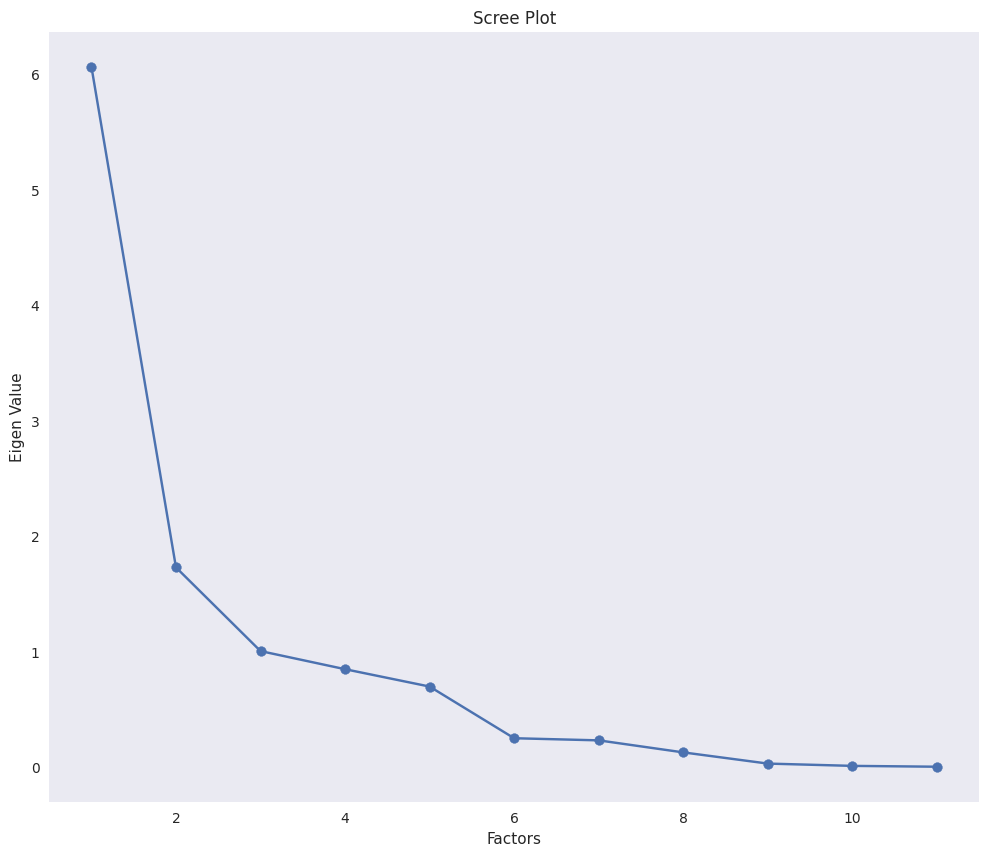

In [25]:
ev,_ = fa.get_eigenvalues()
plt.scatter(range(1,X.shape[1]+1),ev)
plt.plot(range(1,X.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigen Value')
plt.grid()


In [26]:
plt.show()



**Varianza de los factores**



In [27]:
fa_var = pd.DataFrame(fa.get_factor_variance(),index=['Variance','Proportional Var','Cumulative Var'])
fa_var


0         1
Variance          5.777331  1.540923
Proportional Var  0.525212  0.140084
Cumulative Var    0.525212  0.665296

**Comunalidades**



In [28]:
X



array([[ 0.61819185,  0.1855182 , -0.03315823, -0.41967567, -0.81199815,
        -0.07896303, -0.56883092, -0.13417456,  0.11171377,  0.02374128,
        -0.47871151],
       [-0.65799679, -1.41455043, -1.2188549 , -0.73915835,  2.4628817 ,
         1.44660273,  0.24227989, -1.30820197, -0.3736633 , -0.72410894,
        -0.68259412],
       [ 0.5118428 , -0.08703422, -0.154893  , -0.58051363, -0.36029053,
        -1.00756828, -0.93751755,  0.21803366,  0.67798703, -0.35018383,
         1.05040805],
       [ 0.83088996,  0.71251727,  1.59102707,  1.95146577,  0.71251489,
         0.58432643, -0.93751755,  1.03985285,  0.83977939,  0.14838298,
         1.05040805],
       [ 2.7026333 , -0.02909571, -0.17461404, -0.04341232, -0.52968092,
         0.71698432, -0.64256818,  0.3354364 ,  0.03081759, -0.72410894,
        -0.83142842],
       [ 0.46930318,  0.62512668,  0.45353738,  0.69766076, -0.81199815,
         0.91597116, -0.05266953,  0.746346  ,  0.43529849, -0.59946723,
        -0.912

In [29]:
fa_commu = pd.DataFrame(fa.get_communalities(),index=cities.columns,columns=['Communalities'])
fa_commu


Communalities
Area           0.173668
Pop 1980       0.938144
Pop 1990       1.013166
Pop 2000       0.881178
Growth         0.481932
Food           0.698147
PersRoom       0.775535
Water          0.608061
Elec           0.637674
Phones         0.626247
Vehicles       0.484502

**Cargas**



In [30]:
fa_loadings = pd.DataFrame(fa.loadings_,index=cities.columns)
fa_loadings


0         1
Area      0.345352 -0.233239
Pop 1980  0.881838  0.400633
Pop 1990  0.827547  0.573003
Pop 2000  0.578803  0.739030
Growth   -0.679994  0.139788
Food     -0.753242  0.361627
PersRoom -0.801034  0.365895
Water     0.777605 -0.058245
Elec      0.742502 -0.293878
Phones    0.783983 -0.107784
Vehicles  0.646956 -0.256807

**Puntuaciones**



In [31]:
fa_scores = pd.DataFrame(fa.transform(X),index=cities.index)
fa_scores.head()


0         1
City                              
Buenos Aires    0.438958  0.371545
Dhaka          -1.065541 -0.858000
Rio de Janeiro  0.860175 -1.169502
Sao Paolo       0.978201  2.045844
Beijing         0.061341 -0.103778

**Visualización de resultados** 




Con la función biplot que hemos definido antes.



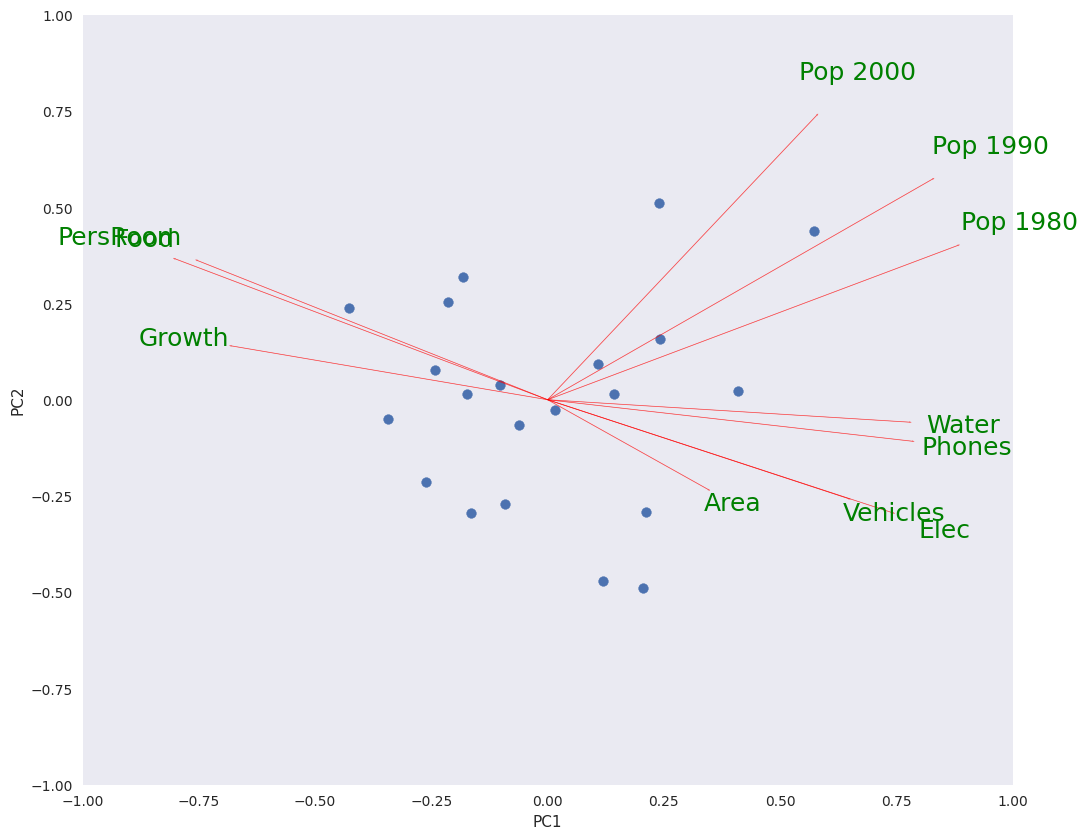

In [32]:
biplot(np.array(fa_scores),np.array(fa_loadings),cities.columns)
plt.show()


Se puede apreciar la rotación para alienar las direcciones de los factores con las observadas en las variables. De esta forma, la proyección sobre el espacio de 2 factores es más clara y permite recoger de forma más clara los efectos de los grupos de variables. 

Aquí, podríamos decir que el factor 1 está asociado con el desarrollo tecnológico en contraposición al hacinamiento, el índice de alimentos y en menor medida el crecimiento y el factor 2 recoge las variables de poblaciones, en especial Pob.2000 que está casi perfectamente alienada, por lo que la contribución es alta y además tiene un módulo (longitud) grande, por lo que su carga es alta. 

A la luz de la solución factorial y especialmente de la baja comunalidad de Area (algo que ya intuímos en un inicio por su bajo MSA), vamos a probar un estudio de FA eliminando esta variable del archivo. 


In [33]:
cities_r = cities.drop(['Area'],axis=1)

X_r=scale(cities_r)

fa = FactorAnalyzer(rotation ='Promax', method='minres',n_factors=2) #cities.shape[1]


fa.fit(X_r)


FactorAnalyzer(n_factors=2, rotation_kwargs={})

In [34]:
#X_r

**Varianza de los factores**



In [35]:
fa_var = pd.DataFrame(fa.get_factor_variance(),index=['Variance','Proportional Var','Cumulative Var'])
fa_var


0         1
Variance          4.366304  2.778616
Proportional Var  0.436630  0.277862
Cumulative Var    0.436630  0.714492

Se aumenta la variabilidad explicada. 

**Comunalidades**


In [36]:
fa_commu = pd.DataFrame(fa.get_communalities(),index=cities_r.columns,columns=['Communalities'])
fa_commu


Communalities
Pop 1980       0.681314
Pop 1990       0.917311
Pop 2000       1.231536
Growth         0.407257
Food           0.931513
PersRoom       0.787584
Water          0.447220
Elec           0.693992
Phones         0.553167
Vehicles       0.494025

Crecimiento y vehículos son las peor representadas en la solución.

**Cargas**


In [37]:
fa_loadings = pd.DataFrame(fa.loadings_,index=cities_r.columns)
fa_loadings


0         1
Pop 1980  0.297132  0.770082
Pop 1990  0.088457  0.953670
Pop 2000 -0.273799  1.075440
Growth   -0.630622 -0.097842
Food     -0.949556  0.172791
PersRoom -0.884162  0.076428
Water     0.628724  0.227872
Elec      0.830986 -0.058775
Phones    0.731977  0.131821
Vehicles  0.701799 -0.038780

**Puntuaciones**



In [38]:
fa_scores = pd.DataFrame(fa.transform(X_r),index=cities_r.index)
fa_scores.head()


0         1
City                              
Buenos Aires    0.262787  0.203463
Dhaka          -0.778606 -1.358196
Rio de Janeiro  1.185529  0.005021
Sao Paolo       0.159247  1.987205
Beijing        -0.241262 -0.444124

Biplot.



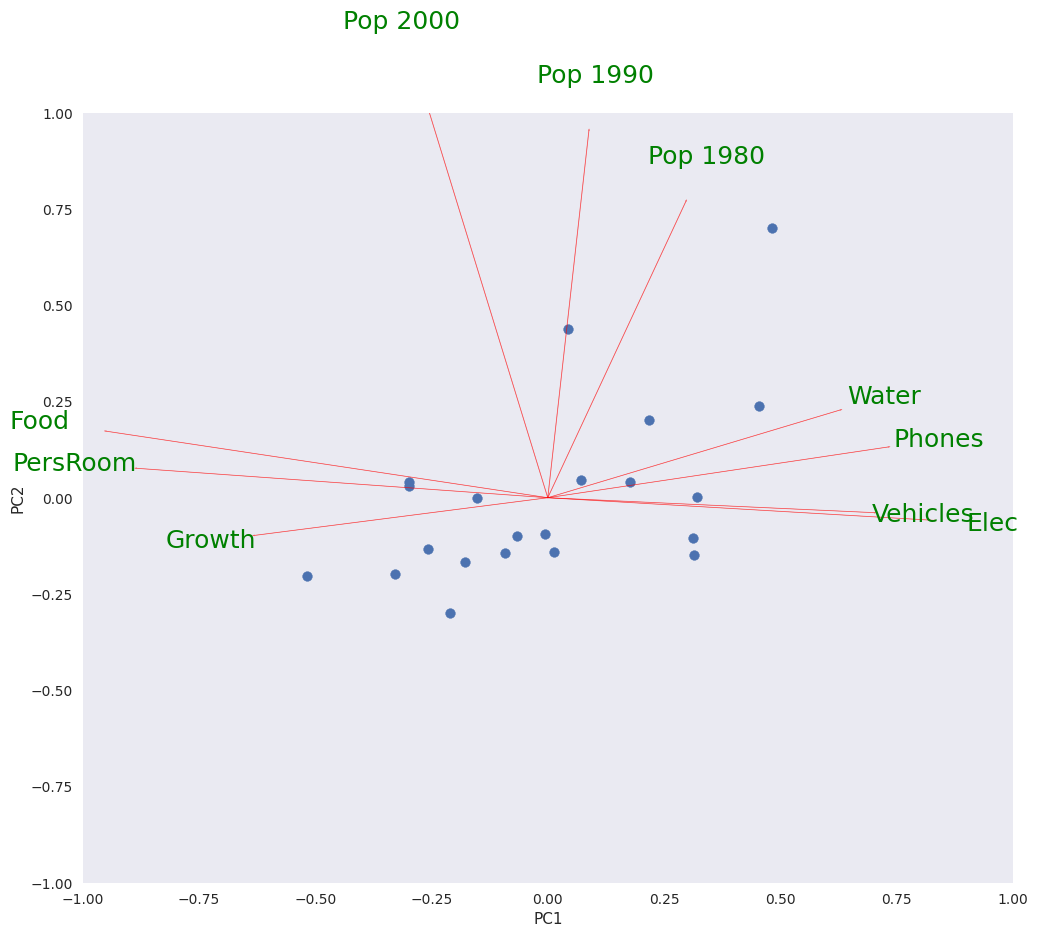

In [39]:
biplot(np.array(fa_scores),np.array(fa_loadings),cities_r.columns)
plt.show()


La rotación logra alinear las variables del eje 1, de tal forma que la interpretación de resultados es más clara. 

# Comparativa PCA-FA-FA_varimax

Exploramos aquí un proceso de comparación de resultados que puede ser de utilidad de cara a la exploración rápida de modelos de reducción de dimensiones y que ilustra las diferencias en las soluciones de PCA, FA y FA con rotación de factores. 

En esta ocasión, vamos a ajustar el FA mediante la función **FactorAnalysis** implementada en *sklearn*, que calcula las cargas mediante el método de máxima verosimilitud (ML).

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html


Vamos a ajustar los 3 métodos a los datos escalados y generar un gráfico de las cargas de las variables en los factores o componentes del espacio reducido. 




 PCA :

          0         1
0  0.358797  0.329726
1  0.333032  0.446924
2  0.236535  0.611141
3 -0.296535  0.107591
4 -0.321067  0.330116
5 -0.328905  0.259426
6  0.333172 -0.019178
7  0.317373 -0.245651
8  0.339349 -0.108871
9  0.279863 -0.240055


 Unrotated FA :

          0         1
0  0.945228  0.286123
1  0.998130  0.042417
2  0.939094 -0.331475
3 -0.458575 -0.772274
4 -0.379803 -0.655352
5 -0.432549 -0.658420
6  0.588479  0.337758
7  0.413298  0.484332
8  0.567006  0.507531
9  0.398535  0.384730


 Varimax FA :

          0         1
0  0.823824  0.544643
1  0.944253  0.326267
2  0.994678 -0.048884
3 -0.218406 -0.871205
4 -0.176385 -0.736631
5 -0.226048 -0.754664
6  0.467217  0.492032
7  0.257419  0.582347
8  0.398061  0.648561
9  0.271775  0.482686


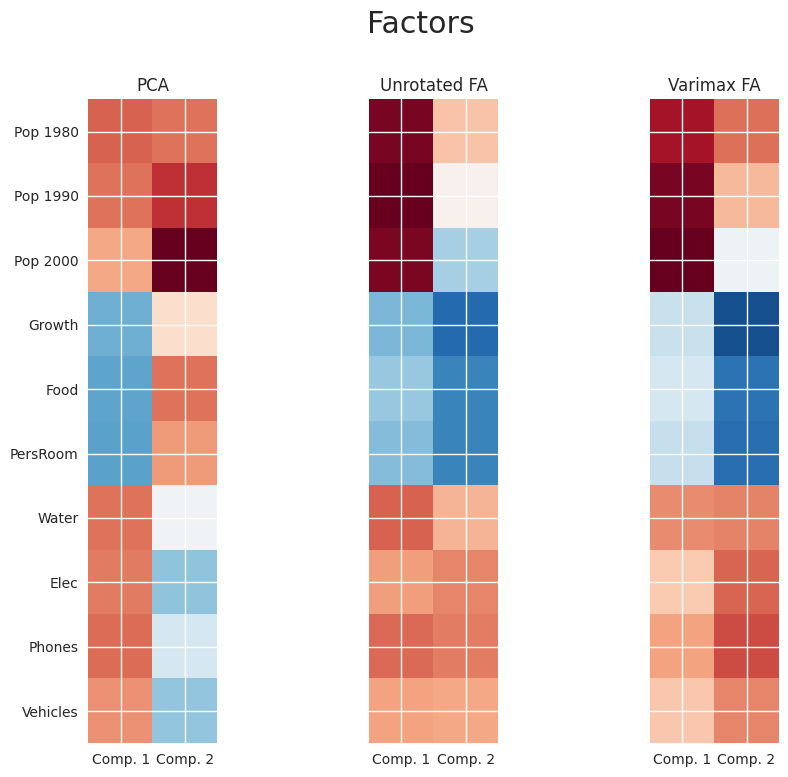

In [40]:
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.preprocessing import scale
n_comps = 2

# Escalado de datos
# ==============================================================================
X=scale(cities_r)

feature_names=cities_r.columns
methods = [
    ("PCA", PCA()),
    ("Unrotated FA", FactorAnalysis()),
    ("Varimax FA", FactorAnalysis(rotation="varimax")),
]
fig, axes = plt.subplots(ncols=len(methods), figsize=(10, 8))

for ax, (method, fa) in zip(axes, methods):
    fa.set_params(n_components=n_comps)
    fa.fit(X)

    components = fa.components_.T
    print("\n\n %s :\n" % method)
    print(pd.DataFrame(components))

    vmax = np.abs(components).max()
    ax.imshow(components, cmap="RdBu_r", vmax=vmax, vmin=-vmax)
    ax.set_yticks(np.arange(len(feature_names)))
    if ax.get_subplotspec().is_first_col():
        ax.set_yticklabels(feature_names)
    else:
        ax.set_yticklabels([])
    ax.set_title(str(method))
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Comp. 1", "Comp. 2"])
    
fig.suptitle("Factors")
plt.tight_layout()
plt.show()


Se observa como las cargas de las variables están bastante más repartidas entre las componentes en el primer caso, estando las poblaciones mejor representadas en la componente 1. Sin embargo, en el análisis factorial el sentido de las componentes cambia y las poblaciones van al factor 2. Además, se observa la alineación de las variables con los ejes con mucha mayor claridad, teniendo diferencias mayores de las cargas en un factor y en otro. La rotación varimax logra alinear más las variables del factor 2, que ahora tienen mayor diferencia de cargas. 